In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import PolynomialFeatures, RobustScaler, OneHotEncoder
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_absolute_error, r2_score, mean_squared_error
from sklearn.pipeline import make_pipeline
from sklearn.compose import ColumnTransformer
import xgboost 
from sklearn import set_config
set_config(transform_output="pandas")


In [2]:
data_path = "Dataset_analyse.csv"
df = pd.read_csv(data_path)

df = df.drop(['month','month_name','budget','director','raw_title','actor_list','rating_press','day',"total_spectator",'distributor','classification_country','country',"hebdo_rank","first_day","first_weekend","casting","award","lang"], axis=1)
df = df.dropna()

df

,year,genre,duration,first_week,copies,director_combined_score,entree_annee,total_actor_scores,distributor_combined_score,year_combined_score,country_combined_score,season,is_holiday
0,2008,comedie,6360,4378720,793,0.467100,190.3,0.559847,0.553998,0.863258,0.723704,winter,0
1,2006,comedie,5820,3906694,950,0.243394,188.8,0.603943,0.341859,0.885471,0.723704,winter,0
2,2000,action,5400,3478850,831,0.384457,165.8,0.434469,0.443038,0.796253,0.723704,spring,0
3,2005,action,8760,3303005,938,0.507118,175.6,0.983180,0.444225,0.834583,0.923321,spring,0
4,2019,animation,7080,3252896,680,0.305411,213.2,0.524373,0.446294,0.850539,0.923321,summer,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2513,1998,drame,6600,49321,49,0.138547,170.6,0.292473,0.140102,0.691216,0.923321,winter,0
2514,2017,animation,5280,48816,267,0.037450,209.4,0.895385,-0.153546,0.850278,0.723704,winter,0
2515,2006,comedie,6120,48535,86,0.126517,188.8,0.246057,0.126877,0.885471,0.923321,autumn,0
2516,2013,drame,8460,47900,81,0.175937,193.7,0.292652,0.171417,0.838728,0.329297,spring,0


In [3]:
X = df.drop(['first_week'], axis=1)
y = df.first_week

X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=True, train_size=0.85, random_state=42)

num_col = list(X.select_dtypes(include=[float,int]).columns)
cat_col = list(X.select_dtypes(include=[object]).columns)

onehotscale_pipeline = make_pipeline(OneHotEncoder(handle_unknown='ignore', sparse_output=False), RobustScaler(with_centering=False))
scale_pipeline = make_pipeline(RobustScaler(with_centering=False))

preprocessing = ColumnTransformer(
    transformers=[
        ('categorical', onehotscale_pipeline, cat_col),
        ('numerical', scale_pipeline, num_col)]
)

polyscale_pipeline = make_pipeline(PolynomialFeatures(2))

my_final_pipeline = make_pipeline(preprocessing)#, polyscale_pipeline)
my_final_pipeline.fit(X_train)

feature_names = my_final_pipeline.get_feature_names_out(X.columns)

In [4]:
# from sklearn import set_config


# set_config(transform_output="pandas")
# model = make_pipeline(
#     my_final_pipeline,
# )
# xdata = model.fit_transform(X_train, y_train)
# xdata.head()

In [5]:
model = make_pipeline(
    my_final_pipeline,
    xgboost.XGBRegressor(n_estimators=1000, max_depth=7, eta=0.1, subsample=0.7, colsample_bytree=0.8)
    )

model.fit(X_train, y_train)

Pipeline(steps=[('pipeline',
                 Pipeline(steps=[('columntransformer',
                                  ColumnTransformer(transformers=[('categorical',
                                                                   Pipeline(steps=[('onehotencoder',
                                                                                    OneHotEncoder(handle_unknown='ignore',
                                                                                                  sparse_output=False)),
                                                                                   ('robustscaler',
                                                                                    RobustScaler(with_centering=False))]),
                                                                   ['genre',
                                                                    'season']),
                                                                  ('numerical',
                                                                   Pipeline(steps=[('robustscaler',
                                                                                    RobustScaler(with_centerin...
                              eval_metric=None, feature_types=None, gamma=None,
                              grow_policy=None, importance_type=None,
                              interaction_constraints=None, learning_rate=None,
                              max_bin=None, max_cat_threshold=None,
                              max_cat_to_onehot=None, max_delta_step=None,
                              max_depth=7, max_leaves=None,
                              min_child_weight=None, missing=nan,
                              monotone_constraints=None, multi_strategy=None,
                              n_estimators=1000, n_jobs=None,
                              num_parallel_tree=None, ...))])

In [6]:
# pyplot.bar(range(len(model[-1].feature_importances_)), model[-1].feature_importances_)
# pyplot.show()

In [7]:
xtrain_tr = model[:-1].fit_transform(X_train)

In [8]:
xtrain_tr.columns

Index(['categorical__genre_action', 'categorical__genre_animation',
       'categorical__genre_aventure', 'categorical__genre_biographique',
       'categorical__genre_comedie', 'categorical__genre_documentaire',
       'categorical__genre_drame', 'categorical__genre_famille',
       'categorical__genre_fantastique', 'categorical__genre_horreur',
       'categorical__genre_mystere', 'categorical__genre_policier',
       'categorical__genre_romantique', 'categorical__genre_sciencefiction',
       'categorical__genre_talkshow', 'categorical__genre_thriller',
       'categorical__season_autumn', 'categorical__season_spring',
       'categorical__season_summer', 'categorical__season_winter',
       'numerical__year', 'numerical__duration', 'numerical__copies',
       'numerical__director_combined_score', 'numerical__entree_annee',
       'numerical__total_actor_scores',
       'numerical__distributor_combined_score',
       'numerical__year_combined_score', 'numerical__country_combined_sco

In [9]:
# pd.Series(model[-1].feature_importances_, index = xtrain_tr.columns)

<Axes: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

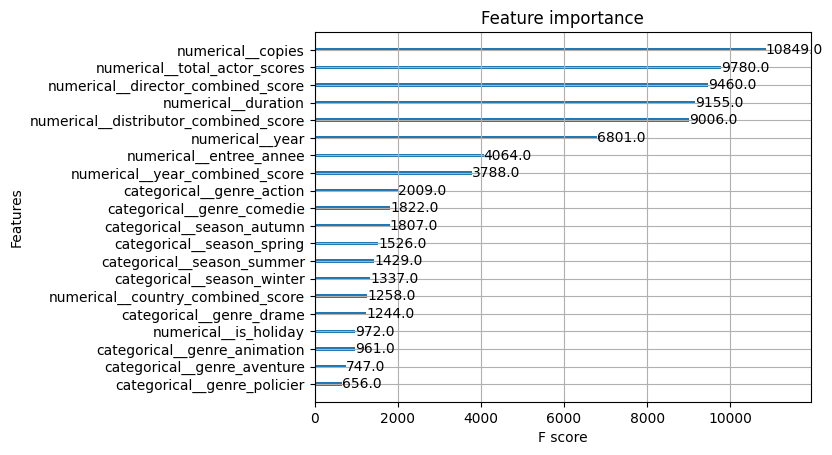

In [10]:
xgboost.plot_importance(model[-1], max_num_features=20)

In [11]:
# y_pred_train = model.predict(X_train)


# residus =  y_pred_train - y_train


# weights = np.exp(-abs(residus) / residus.std())
# model.fit(X_train, y_train, lasso__sample_weight=weights)




y_pred = model.predict(X_test)
# y_pred = model.predict(df_test)
# print(y_pred)

In [12]:

r2_cleaned = r2_score(y_test, y_pred)
mse_cleaned = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
rmse_cleaned = np.sqrt(mse_cleaned)

print("Performance du modèle :")
# print(model.best_params_)
print(f"R2 Score: {r2_cleaned:.4f}")
print(f"MAE: {mae:.2f}")
print(f"RMSE: {rmse_cleaned:.2f}")

Performance du modèle :
R2 Score: 0.8031
MAE: 88512.18
RMSE: 162431.96


In [13]:
from joblib import dump, load

model_path = 'model.pkl'
dump(model, model_path)
model = load('model.pkl')

In [14]:
def predict_prod(model,data):
    # Convertir la liste de listes en DataFrame
    df = pd.DataFrame(data, columns=['year','season', 'entree_annee','is_holiday','month','day','director', 'country','classification_country','classification_acteurs' ,'duration', 'genre', 'copies', 'rating_press','budget','distributor'])
    predictions = model.predict(df)
    return predictions

predict_prod(model,[[2024,'spring', 180.8,1,3, 8,2, "etatsunis",3,3, 5640, "animation", 696, 3.4, 85000000, 3]])

ValueError: columns are missing: {'country_combined_score', 'distributor_combined_score', 'total_actor_scores', 'year_combined_score', 'director_combined_score'}